In [60]:
import requests,json,datetime
from urllib.parse import quote 
import pandas as pd
import numpy as np
import folium

In [61]:
with open('data/sub_arr_info_key.txt') as f:
    info_key = f.read()

In [62]:
df_st = pd.read_csv('data/St_addr_20221122.csv',encoding='euc-kr')
df_st = df_st[['역명','도로명주소']]
df_st['역명'] = df_st['역명'].str.replace('(', ' ',regex=False).str.split().str[0]

In [63]:
target = input('역명 입력')
target = target[:-1] if target[-1] == '역' else target

In [64]:
base_url = "http://swopenAPI.seoul.go.kr/api/subway/"
params1 = f"{info_key}/json/realtimeStationArrival/0/8/"
params2 = quote(target)
url = f"{base_url}{params1}{params2}"
response = requests.get(url)
res = json.loads(response.text)

In [65]:
df = pd.DataFrame(res['realtimeArrivalList'])
df = df[['updnLine','trainLineNm','statnNm','bstatnNm','arvlMsg2','arvlMsg3','barvlDt','arvlCd']]

In [66]:
df

,updnLine,trainLineNm,statnNm,bstatnNm,arvlMsg2,arvlMsg3,barvlDt,arvlCd
0,상행,구로행 - 세류방면,병점,구로,병점 도착,병점,0,1
1,상행,광운대행 - 세류방면,병점,광운대,[3]번째 전역 (오산),오산,0,99
2,하행,서동탄행 - 세마방면,병점,서동탄,병점 도착,병점,0,1
3,하행,청량리행 - 세마방면,병점,청량리,[34]번째 전역 (회기),회기,0,99
4,하행,신창행 - 세마방면,병점,신창,전역 도착,세류,0,5


In [67]:
df1 = df[df.updnLine == '상행'].copy()
df2 = df[df.updnLine == '하행'].copy().reset_index(drop=True)

In [68]:
def kakao_location(place):
    with open('../04.지도시각화/data/kakaoapikey.txt') as f_:
        kakao_key = f_.read()
    base_url = "https://dapi.kakao.com/v2/local/search/address.json"
    url = f'{base_url}?query={quote(place)}'
    header = {'Authorization':f'KakaoAK {kakao_key}'}
    result = requests.get(url, headers=header).json()
    lat_ = float(result['documents'][0]['y'])
    lng_ = float(result['documents'][0]['x'])
    return lat_,lng_

In [69]:
def rtn_addr(target):
    str_addr = df_st[df_st.역명 == target].도로명주소.values[-1]
    return str_addr.strip()

In [70]:
temp1 =[]
for i in df1.index:
    bst = df1.arvlMsg3[i].strip()
    temp1.append(kakao_location(rtn_addr(bst)))

df_test = pd.DataFrame(temp1,columns=('lat','lng'))
df1 = pd.concat([df1, df_test], axis=1)
df1

,updnLine,trainLineNm,statnNm,bstatnNm,arvlMsg2,arvlMsg3,barvlDt,arvlCd,lat,lng
0,상행,구로행 - 세류방면,병점,구로,병점 도착,병점,0,1,37.206802,127.033243
1,상행,광운대행 - 세류방면,병점,광운대,[3]번째 전역 (오산),오산,0,99,37.145895,127.066845


In [71]:
temp1 =[]
for i in df2.index:
    bst = df2.arvlMsg3[i].strip()
    temp1.append(kakao_location(rtn_addr(bst)))
    
df_test = pd.DataFrame(temp1,columns=('lat','lng'))
df2 = pd.concat([df2, df_test], axis=1)
df2

,updnLine,trainLineNm,statnNm,bstatnNm,arvlMsg2,arvlMsg3,barvlDt,arvlCd,lat,lng
0,하행,서동탄행 - 세마방면,병점,서동탄,병점 도착,병점,0,1,37.206802,127.033243
1,하행,청량리행 - 세마방면,병점,청량리,[34]번째 전역 (회기),회기,0,99,37.589744,127.058035
2,하행,신창행 - 세마방면,병점,신창,전역 도착,세류,0,5,37.244655,127.013978


In [72]:
lat,lng = kakao_location(rtn_addr(target))
print(target,lat,lng)

병점 37.2068017946815 127.033243427141



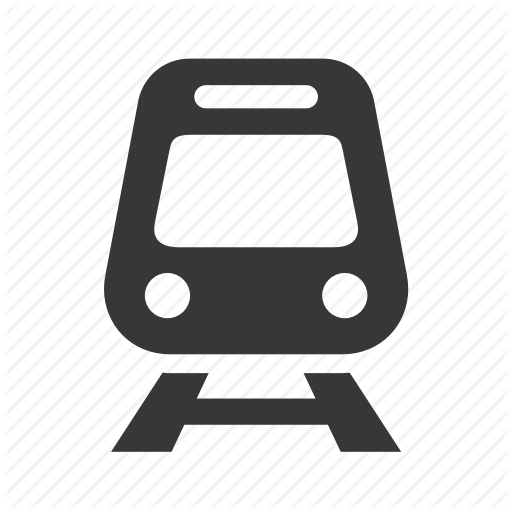
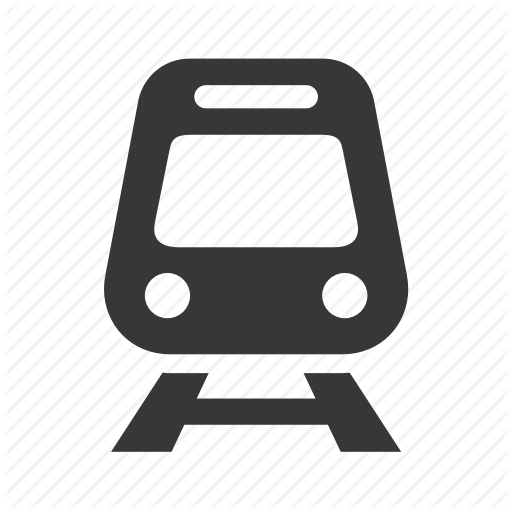
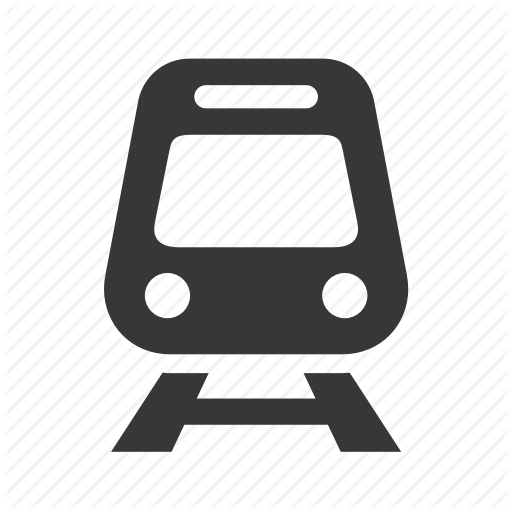
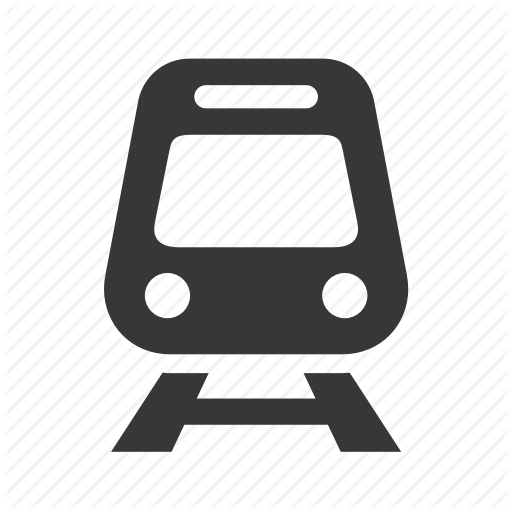
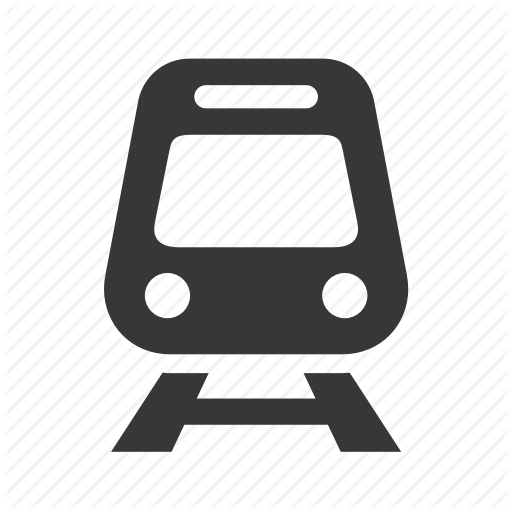

In [73]:
stn_map = folium.Map(location=[lat,lng],zoom_start=13)
for i in df1.index:
    pushpin = folium.CustomIcon(f'data/micon.jpg', icon_size=(40,40))
    folium.Marker(
        location=[df1.lat[i], df1.lng[i]],                     
        popup=folium.Popup(df1.arvlMsg2[i],max_width=300),
        tooltip=df1.arvlMsg3[i],
        icon=pushpin
    ).add_to(stn_map)
for i in df2.index:
    pushpin = folium.CustomIcon(f'data/micon.jpg', icon_size=(40,40))
    folium.Marker(
        location=[df2.lat[i], df2.lng[i]],                     
        popup=folium.Popup(df2.arvlMsg2[i],max_width=300),
        tooltip=df2.arvlMsg3[i],
        icon=pushpin
    ).add_to(stn_map)
title_html = '<h3 align="center" style="font-size:20px">지하철 실시간 도착</h3>'
stn_map.get_root().html.add_child(folium.Element(title_html))
stn_map

In [87]:
# 상행 하행 구분 좀더 명확하게
# 노선별로 아이콘 색 다르게
# 급행도 아이콘 다르게
# 검색한 역 아이콘 다르게
# 어? 근데 html에서 보여주려면 .values로 꺼내야 함?
what = df2.iloc[:,:6].values

In [88]:
what

array([['하행', '서동탄행 - 세마방면', '병점', '서동탄', '병점 도착', '병점'],
       ['하행', '청량리행 - 세마방면', '병점', '청량리', '[34]번째 전역 (회기)', '회기'],
       ['하행', '신창행 - 세마방면', '병점', '신창', '전역 도착', '세류']], dtype=object)